<a href="https://colab.research.google.com/github/mwahajkhan/Supervised-ML-Regression-/blob/main/Regression_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Chaining multiple data processing steps together using Pipeline

* Using the KfFolds object to split data into multiple folds

* Performing cross validation using sickit learn with **cross_val_predict** and **GridSearchCV**

In [1]:
!pip install tqdm seaborn pandas numpy scikit-learn

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [3]:
!pip install requests

import requests

def download(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            f.write(response.content)

path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"

# Download the dataset
download(path, "boston_housing_clean.pickle")

# Import pandas library
import pandas as pd

# Read the file and assign it to variable "boston"
boston = pickle.load(open('boston_housing_clean.pickle', "rb"))

In [4]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [5]:
#Transforming to pandas dataframe
boston_data = boston['dataframe']
boston_description = boston['description']


In [6]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


*To predict future values, given the features and information given in this dataset*

> KFold initiates a sickit learn cross validation object

> Using K Fold to initiate three different folds i.e. train/test sets

In [7]:
#Features X and target variable Y
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [8]:
#Initiate the KFold object before using, and passing args n_splits indicate three folds
kf = KFold(shuffle=True, random_state=72018, n_splits=3)


In [9]:
#Generator object, a list where each value is a tuple
kf.split(X)

<generator object _BaseKFold.split at 0x79204f219310>

In [10]:
X.shape

(506, 13)

In [11]:
#First part of tuple all indicies set to train index, and other for test index
for train_index, test_index in kf.split(X):
  print("Train index:", train_index[:10], len(train_index))
  print("Test index:", test_index[:10], len(test_index))
  print(' ')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169
 
Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169
 
Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168
 


* 169 + 337 = 506 indicies, meaning the train_index, and test_index are values taken from dataset (X), and split exactly 169, and randomly taken from the dataset for test data. This process is conducted thrice, as we initiated our kfold with three folds.

In [12]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test = (X.iloc[train_index, :], #Extracting train_index rows and all columns
                                      X.iloc[test_index, :],
                                      y[train_index],
                                      y[test_index])
  #fitting the model on training data
  lr.fit(X_train, y_train)

  #making predictions on trained data
  y_pred = lr.predict(X_test)

  #Comparing actual values, with predictions
  score = r2_score(y_test.values, y_pred)

  scores.append(score)

scores

[0.6719348798472742, 0.7485020059212382, 0.6976807323597771]

* Three differrent results for each train and test sets

## Scaling Data as go throug the folds

In [13]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
   X_train, X_test, y_train, y_test = (X.iloc[train_index, :],
                                      X.iloc[test_index, :],
                                      y[train_index],
                                      y[test_index])

   #Scaling using fit_transform
   X_train_s = s.fit_transform(X_train) #s = subtract mean divide by sd

   #fit lr model on training set
   lr.fit(X_train_s, y_train)

   #bring test set on same scale
   X_test_s =s.transform(X_test)

   #Passing scaled test data in lr model fitted to train data to come with predictions
   y_pred = lr.predict(X_test_s)

   #Calculating r2 score, using original values, and predicted
   score = r2_score(y_test.values, y_pred)
   scores.append(score)

In [14]:
scores

[0.6719348798472715, 0.7485020059212382, 0.6976807323597745]

* The scores are same as previous method, as vanialla linear regression with no regularization, scaling does not change the performance.

**Pipeline and cross_val_predict**


> Pipeline allows to chain together multiple operators on data that both have a fit method.

> We can chain together more then two steps, as long as each step has as **fit_transform** method so the output of one can be used as input of next, and the last step has a  **fit**

In [15]:
s = StandardScaler()
lr = LinearRegression()

**Combining multiple steps into pipeline**

> A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help in identifying which step are on, and to allow us to specify parameters at that step.  

> This pipeline will first scale data, and then pass that through a linear regression, and allows to bypass previous steps.

In [16]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

### `cross_val_predict`

cross_val_predict`] is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [ ]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

> Here, [estimator] from pipeline, will bring in scaled, and transformed data.

> No , initial splits. For our initial values of X, the {cross_val_predict} will do the splitting itself.

> Passing in the kf initialized earlier and passing in to cross_val_predict will specify the number of folds, for data splitting.

In [17]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [18]:
r2_score(y, predictions)

0.7063531064161561

* Similar results, just like that of in earlier steps where called each single one by one.

In [19]:
np.mean(scores) #both prev(mean of three folds) and new value identical

0.7060392060427615

* Both are almost identical

##Hyper Parameter Tuning

> **Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of given sample.

> We learn the parameters, but choose the hyper parameters.

> * **Hyperparameters** are part of model that we tune ourselves. **Parameters** are learned by the model using machine learning.

> **Complexity Vs Error** Testing different hyperparameters to see which one will lead to right level of complexity to minimize error or handout/test set.

> Tuning hyperparameters an increase or decrease complexity of the model

> The goal of hyperparameters is to choose the points in function that generalize unseen data well. So tuning unti find best balance between error and complexity.

### Mechanics

We can generate an exponentially spaced range of values using the numpy [`geomspace`]function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Using this function to generate a list of length 10 called `alphas` for hyperparameter tuning:



In [20]:
#example geomspace range = 10 -100, num = 10
#Every other value is a multiple of previous
show = np.geomspace(10, 100, 10)
show


array([ 10.        ,  12.91549665,  16.68100537,  21.5443469 ,
        27.82559402,  35.93813664,  46.41588834,  59.94842503,
        77.42636827, 100.        ])

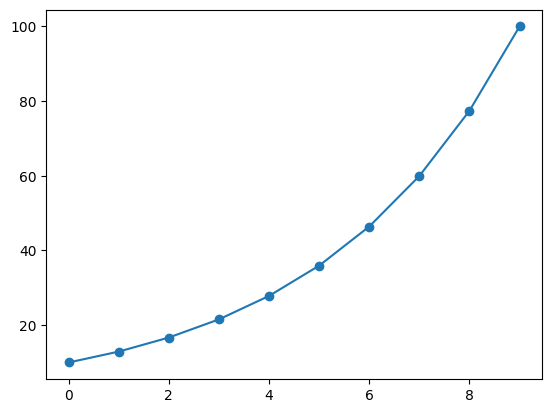

In [ ]:
plt.plot(show, 'o-')

In [21]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

* The function geomspace generates exponentially spaces range of values.

* **Tuning the [Alpha] hyperparameters for lasso regression** : Which one of the alpha value will lead to the highest score for holdout/test set.

* Using either **lasso** or **ridge**, always scale data first

In [28]:
scores = []
coefs = []
for alpha in alphas:

  #for every alpha, initiate the lasso
  #passing alpha, the higher the value the less complex the model
  las = Lasso(alpha=alpha, max_iter=100000)

  #create estimator using pipeline
  estimator = Pipeline([("scaler", s),
                        ("lasso_regression", las)])

  #Cross validation, making predictions
  predictions = cross_val_predict(estimator, X, y, cv = kf)

  score = r2_score(y, predictions)

  scores.append(score)

In [29]:
#Checking scores for each one of the alphas
list(zip(alphas, scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052063),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884888)]

**Trade off between Highly complex vs least comlex model**:

> Setting alpha value 0.0000001 most complex model

> Setting alpha value 1 takes away certain values or features as each value corresponds to a coefficent

In [24]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [25]:
Lasso(alpha=1).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

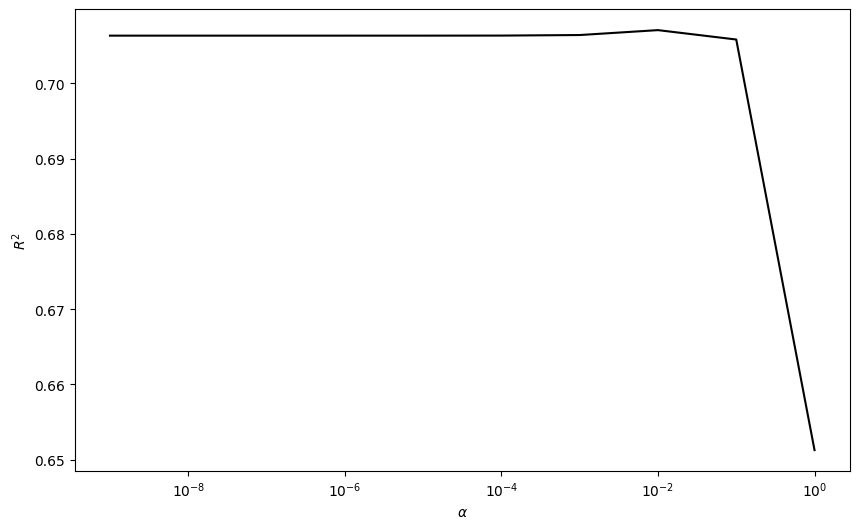

In [26]:
#Higher complexity(alpha value) vs error rate
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, scores, '-0')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

**Adding polynomila features to pipeline**

* This significantly increases the accuracy of the cross validation

* Then re run cross validation

In [31]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.001, 10, 5)
for alpha in alphas:
  las = Lasso(alpha=alpha, max_iter=100000)

  #Good practice keep adding features above scaler in pipeline
  estimator = Pipeline([("make_higher_degree", pf),
                        ("scaler", s),
                        ("lasso regression", las)])

  predictions = cross_val_predict(estimator, X, y, cv=kf)

  score = r2_score(y, predictions)

  scores.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.084e+01, tolerance: 2.735e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e+01, tolerance: 2.777e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.885e+01, tolerance: 3.030e

In [32]:
scores

[0.7697086980421659,
 0.8591002095361691,
 0.8280423631185617,
 0.7328688516176427,
 -0.000616160136140298]

In [33]:
alphas

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

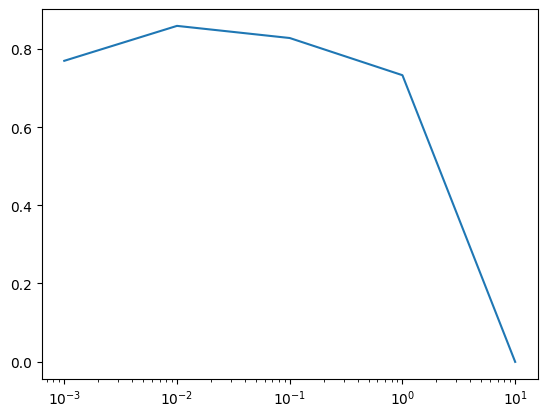

In [34]:
plt.semilogx(alphas, scores)

*at **0.01** hyperparameter, we got the optimal value of hyperparameter which will generalize well to new data coming.

In [35]:
#Once found the optimal hyperparameter(alpha~1e-2=0.01), make the model & train on all data

best_estimator = Pipeline([("make_higher_degree", PolynomialFeatures(degree=2)),
                           ("standar scaler", s),
                           ("lasso_regression", Lasso(alpha=0.01, max_iter=10000))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9032551408154241

In [36]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        4.61127587e+00,  0.00000000e+00,  6.24240557e-01,  0.00000000e+00,
       -7.22878514e+00,  9.74968793e+00,  0.00000000e+00,  0.00000000e+00,
        6.34548325e-01,  0.00000000e+00,  9.95741679e-01, -5.51374291e-03,
       -0.00000000e+00,  2.44370838e+00, -2.40444044e+00, -0.00000000e+00,
       -0.00000000e+00, -2.23044443e-01, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -2.88128934e-01,  5.17203914e-01,  3.07715719e-01,
       -3.39853933e-01, -9.86590910e-02, -0.00000000e+00,  2.72847487e-01,
       -0.00000000e+00, -6.39829763e-01, -3.16474346e-01,  1.44555554e+00,
        0.00000000e+00, -0.00000000e+00, -8.84630187e-01,  1.32081558e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  2.63148300e+00,
       -2.62941147e-01,  0.00000000e+00,  9.08410143e-01, -8.17144528e-01,
        0.00000000e+00, -4.31628234e+00,  5.53254405e-01, -2.91912598e+00,
       -4.68486241e+00,  

**Repeating same process with [ridge regression]**

> Estimating either [Ridge] or [Lasso] performs best with its optimal hyperparameters on Boston Dataset

> Repeating same process for Ridge:

  > *Adding polynomial Features*

  >

> doing cross-validation and  for each one of these Alphas, either reducing complexity a ton or just a bit, to find the right balance in regards to complexity to minimize the error on our holdout sets.

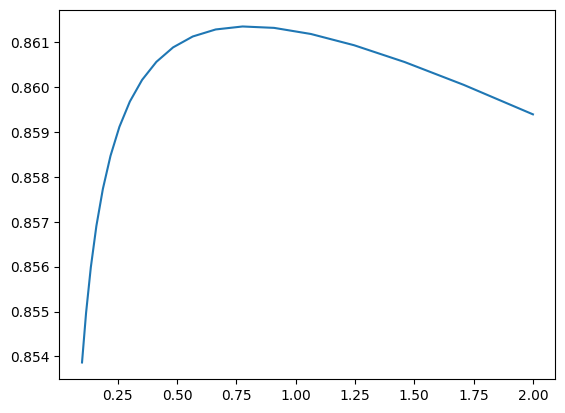

In [72]:
#pf object
pf = PolynomialFeatures(degree=2)

#Alphas to search through
alphas = np.geomspace(0.1, 2, 20)
scores=[]
for alpha in alphas:

  #passing max iteration to make sure it will converge

    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("polynomial_features", pf),
        ("scaler", s),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

* Increased alopha to reduce complexity and got optimal point at 0.75 hyperparameter

**Looking at the interpretability of model:**

> Standerize data

> Fit and Predict on entire dataset

> Seeing latest Co-efficents:

dict(zip(model.coef_, pf.get_feature_names(input_features = X.columns)))

In [82]:
best_estimator = Pipeline([("make_higher_degree", PolynomialFeatures(degree=2, include_bias=False)),
    ("Scaler", StandardScaler()),
    ("lasso_regression", Lasso(alpha=0.01))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.387e+02, tolerance: 4.272e+00
  model = cd_fast.enet_coordinate_descent(


0.9047578542960124

*To access portion of the pipeline, use .named_steps()*

In [84]:
#list all the features along with newly created features in make_higher_degree through pf using pipeline.
best_estimator.named_steps["make_higher_degree"].get_feature_names_out(input_features=X.columns)

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT', 'CRIM^2', 'CRIM ZN', 'CRIM INDUS',
       'CRIM CHAS', 'CRIM NOX', 'CRIM RM', 'CRIM AGE', 'CRIM DIS',
       'CRIM RAD', 'CRIM TAX', 'CRIM PTRATIO', 'CRIM B', 'CRIM LSTAT',
       'ZN^2', 'ZN INDUS', 'ZN CHAS', 'ZN NOX', 'ZN RM', 'ZN AGE',
       'ZN DIS', 'ZN RAD', 'ZN TAX', 'ZN PTRATIO', 'ZN B', 'ZN LSTAT',
       'INDUS^2', 'INDUS CHAS', 'INDUS NOX', 'INDUS RM', 'INDUS AGE',
       'INDUS DIS', 'INDUS RAD', 'INDUS TAX', 'INDUS PTRATIO', 'INDUS B',
       'INDUS LSTAT', 'CHAS^2', 'CHAS NOX', 'CHAS RM', 'CHAS AGE',
       'CHAS DIS', 'CHAS RAD', 'CHAS TAX', 'CHAS PTRATIO', 'CHAS B',
       'CHAS LSTAT', 'NOX^2', 'NOX RM', 'NOX AGE', 'NOX DIS', 'NOX RAD',
       'NOX TAX', 'NOX PTRATIO', 'NOX B', 'NOX LSTAT', 'RM^2', 'RM AGE',
       'RM DIS', 'RM RAD', 'RM TAX', 'RM PTRATIO', 'RM B', 'RM LSTAT',
       'AGE^2', 'AGE DIS', 'AGE RAD', 'AGE TAX', 'AGE PTRATIO', 'AGE B',
       '

In [85]:
#Listing all the coefficents for these features
best_estimator.named_steps["lasso_regression"].coef_

array([-0.00000000e+00, -3.82985461e+00,  3.48014576e+00,  4.05748586e+00,
        3.45173893e-01,  2.08468944e+00,  1.60991201e+00, -1.75204581e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.60862339e+00,
        0.00000000e+00,  1.01639298e+00,  7.51603355e-02, -0.00000000e+00,
        2.32329150e+00, -6.67658168e-01, -0.00000000e+00, -0.00000000e+00,
       -7.25136540e-01, -9.62698698e-01, -0.00000000e+00, -0.00000000e+00,
       -4.80740000e-01,  3.04296783e-01,  2.81472433e-01, -2.53696875e-01,
       -1.08689446e-01, -0.00000000e+00,  1.48188354e+00, -0.00000000e+00,
       -0.00000000e+00, -4.52419731e-02,  1.96602697e+00,  1.21373976e+00,
        0.00000000e+00, -8.12101771e-01,  1.52974702e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  1.42509055e+00, -6.27762978e-01,
       -0.00000000e+00,  0.00000000e+00, -2.91005018e+00,  0.00000000e+00,
       -4.41676730e+00,  4.61305914e-01, -2.99708915e+00, -4.35715157e+00,
        6.63885993e-01,  

In [86]:
#zip the output of these two steps together i.e. Adding coefficents and lasso , and pass into dataframe
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names_out(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [87]:
df_importances.sort_values(by=1)
#First table is all the features, and second table <1> is the magnitude of that coefficent

,0,1
72,RM TAX,-7.484883
63,NOX RAD,-5.324131
71,RM RAD,-4.516639
93,RAD LSTAT,-4.455994
48,INDUS LSTAT,-4.416767
...,...,...
3,CHAS,4.057486
103,LSTAT^2,5.467342
95,TAX PTRATIO,7.142666
68,RM^2,8.325413


In [90]:
df_importances.sort_values(by=1)
#RM&Tax rate has very negative effect, while rad pt ratio has highest positive effect

,0,1
72,RM TAX,-7.484883
63,NOX RAD,-5.324131
71,RM RAD,-4.516639
93,RAD LSTAT,-4.455994
48,INDUS LSTAT,-4.416767
...,...,...
3,CHAS,4.057486
103,LSTAT^2,5.467342
95,TAX PTRATIO,7.142666
68,RM^2,8.325413


In [92]:
print(boston_description)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [45]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [46]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [47]:
df_importances.sort_values(by=1)

,0,1
13,x12,-3.395426
8,x7,-2.561614
10,x9,-1.722662
94,x8 x12,-1.124408
72,x5 x8,-1.085987
...,...,...
9,x8,1.127783
79,x6 x8,1.363407
96,x9 x10,1.962870
6,x5,3.326791


###Grid Search CV

> This function encapsulates the following steps:

* KFolds (Summarizes for loops for the K fold)

* cross_val_predict (passing that kfolds through cross val predict)

* Hyper Parameters (For loop through each alphas/hyper parameter and passing it through cross_val_predict)

* score

In [105]:
from sklearn.model_selection import GridSearchCV

#same estimatore as before
estimator = Pipeline([
                      ("polynomial_features", PolynomialFeatures()),
                      ("Standard", StandardScaler()),
                      ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}


grid = GridSearchCV(estimator, params, cv=kf)

* .fit will fit the pipeline by running through each of the hyperparameters

In [106]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('Standard', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [108]:
#refine output to see best score and parameters
grid.best_score_, grid.best_params_

(0.8546333782070428,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 4.0})

**Using grid to predict X values as:**

> It tests against all differrent holdout sets

> After that it finds the best hyperparameters that fit for generalization for new data-sets.

> Using the hyperparameters to learn parameters on the entire data set, as predictions improve with seeing new data, and should generalize well on entire data.

> Fitting Grid on entire data, and the results should improve.

In [111]:
#running grid to predict on entire data
#Learn parameters on entire dataset
y_predict = grid.predict(X)


In [112]:
#Includes both in sample and out of sample
r2_score(y, y_predict)

0.8964707714558113

In [113]:
#Extract coeffeicents form Ridge used in pipline from [.named_steps] via pipeline function {best_estimator}.
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  2.47147038e-01, -1.18377806e+00,  1.11700133e+00,
        1.02268931e+00,  1.11573592e+00,  2.63515343e+00,  1.60400844e+00,
       -2.44378403e+00,  2.67549673e+00,  1.18120641e+00,  3.00931414e-01,
        7.17164316e-01,  5.46697603e-01,  1.16368605e+00,  2.78583120e-01,
        4.15770986e-01,  2.45396270e+00, -1.07012228e+00, -8.15812777e-01,
       -2.95036466e-01, -8.26480829e-01, -4.23552596e-01, -4.33022591e-02,
        8.34930099e-02, -4.92838202e-01,  5.12447325e-01,  5.88355149e-01,
       -3.50662224e-01, -1.39184102e-01, -2.99737738e-01,  1.02696466e+00,
        1.47705864e-02, -6.87593891e-01, -3.12176710e-01,  1.26476807e+00,
        1.01258007e+00, -5.51925730e-01, -8.62269698e-01,  8.78832853e-01,
        6.75975245e-02,  5.91362874e-01, -1.45086000e+00,  1.09286634e+00,
       -7.69112663e-01,  1.16978387e+00,  1.29460196e+00, -7.36888615e-01,
        7.29205860e-01, -2.44086792e+00,  1.02268931e+00, -2.26162754e+00,
       -2.56091292e+00,  

In [121]:
pd.DataFrame(grid.cv_results_).sort_values(ascending=False, by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
30,0.007040,0.000837,0.003012,0.000067,2,4.0,"{'polynomial_features__degree': 2, 'ridge_regr...",0.841707,0.862537,0.859656,0.854633,0.009216,1
31,0.007805,0.000239,0.003105,0.000067,2,4.228267,"{'polynomial_features__degree': 2, 'ridge_regr...",0.840967,0.862184,0.858916,0.854022,0.009328,2
32,0.009424,0.002014,0.004117,0.001362,2,4.46956,"{'polynomial_features__degree': 2, 'ridge_regr...",0.840197,0.861800,0.858129,0.853375,0.009438,3
76,0.018297,0.000498,0.004630,0.000089,3,9.720724,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827225,0.870671,0.860263,0.852720,0.018521,4
77,0.018621,0.000437,0.005836,0.001764,3,10.275454,"{'polynomial_features__degree': 3, 'ridge_regr...",0.827394,0.870414,0.860336,0.852715,0.018371,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.006862,0.000235,0.002728,0.000013,1,4.994243,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672067,0.748104,0.702579,0.707583,0.031243,86
3,0.006406,0.000102,0.002717,0.000025,1,4.724624,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672081,0.748141,0.702375,0.707533,0.031265,87
2,0.006653,0.000068,0.002743,0.000073,1,4.46956,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672093,0.748175,0.702178,0.707482,0.031286,88
1,0.007595,0.001093,0.002863,0.000130,1,4.228267,"{'polynomial_features__degree': 1, 'ridge_regr...",0.672103,0.748207,0.701986,0.707432,0.031307,89


## **Summary**

1. Validationg through general K folds.

2. Using cross val predicts so that we can see the scores for each one of those K folds in assessing fashion.

3. Using hyper-parameters in order to look at multiple versions of the same model, reducing or increasing the complexity of that model to see which one performs best on our holdout set.

4. Using grid search CV, to find the best hyper-parameters, given the hyper-parameters such as we gave degree 1, 2, or 3, in Params{} dictionary along with Alphas within this range of 4-20. The Grid ultimately fit on all the data and as a result we have:

> the best hyper-parameters which are chosen from cross validating from degree 1, 2,3 and alphas


> Grid tested across each one alphas, to give best parameters as they will be learned on the entire data-set.